In [1]:
import numpy as np
import math
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
import string
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn import datasets

In [2]:
text_data = datasets.load_files(r"20_newsgroups")
x = text_data.data
y = text_data.target

In [3]:
print(type(x),type(y))

<class 'list'> <class 'numpy.ndarray'>


In [4]:
print(len(x),len(y))

19997 19997


In [5]:
# Cleaning the training data using regex library of python
X = []

for i in range(len(x)):
    # Removing all the non-word characters ie not present in {a-z, A-Z, 0-9, _}
    text = re.sub(r'\W',' ',str(x[i]))
    
    # Converting multiple spaces to single blank space
    text = re.sub(r'\s+',' ',text, flags=re.I)
    
    # Removing the prefixed b from the text
    text = re.sub(r'^b\s+','',text)
    
    # Removing all the numbers
    text = re.sub(r'\d+','',text)
    
    # Converting to lower case
    text = text.lower()
    
    X.append(text)

In [6]:
print(type(X),len(X))

<class 'list'> 19997


In [7]:
# Download the Stop Words
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /Users/divij/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stop_words = stopwords.words('english')
print(len(stop_words))
print(stop_words)

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

In [9]:
# Building the initial dictionary of all the unique words and their frequencies
dictionary = {}

for i in X:
    for word in i.split():
        if word not in stop_words:
            dictionary[word] = dictionary.get(word,0) + 1

In [10]:
print(len(dictionary))

164593


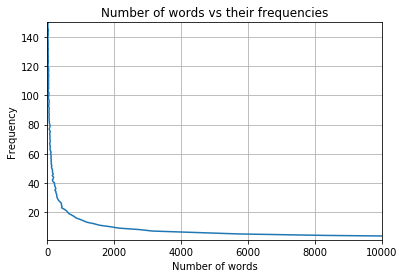

In [34]:
# Plotting a line graph for the number of words vs the frequencies
temp = {}
for i in dictionary:
    temp[dictionary[i]] = temp.get(dictionary[i],0) + 1

x_axis = []
y_axis = []
for i in sorted(temp.keys()):
    y_axis.append(i)
    x_axis.append(temp[i])
plt.plot(x_axis,y_axis)
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.title('Number of words vs their frequencies')
plt.axis([0,10000,1,150])
plt.grid()
plt.show()

In [13]:
# Selecting a cutoff freq ie discarding the words having a freq below the cutoff
cutoff = 120
final_dict = {}
for i in dictionary:
    if dictionary[i] >= cutoff:
        final_dict[i] = dictionary[i]
print(len(final_dict))

5078


In [25]:
# Building a 2D np array of the words and their frequencies
words = list(final_dict.keys())
X_array = np.zeros((len(X),len(final_dict)))

for i in range(len(X)):
    curr_doc = X[i].split()
    for word in curr_doc:
        if word in words:
            j = words.index(word)
            X_array[i][j] += 1
print(X_array.shape)

(19997, 5078)


In [43]:
X_train = X_array
Y_train = y
X_train

array([[1., 1., 2., ..., 0., 0., 0.],
       [0., 2., 3., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [89]:
# Defining a fit function which makes a result dictionary containing frequencies of words for each class present in Y
def fit(X_train,Y_train):
    result = {}
    classes = set(Y_train)
    result['total_rows'] = len(Y_train)
    for curr_class in classes:
        result[curr_class] = {}
        class_total = 0
        X_class = X_train[Y_train == curr_class]
        Y_class = Y_train[Y_train == curr_class]
        num_features = X_train.shape[1]
        result[curr_class]['total_class_rows'] = len(Y_class)
        for j in range(num_features):
            result[curr_class][j] = X_class[:,j].sum()
            class_total += result[curr_class][j]
        result[curr_class]['total_class_freq'] = class_total
    return result
    
# This function calculates the probability of the given class based on the value of a single datapoint.    
def probability(curr_class,result,row):
    output = np.log(result[curr_class]['total_class_rows']) - np.log(result['total_rows'])
    num_features = len(result[curr_class].keys())-2
    for j in range(len(row)):
        num = result[curr_class][j]+1
        denom = result[curr_class]['total_class_freq'] + len(row)
        prob = np.log(num) - np.log(denom)
        output += row[j]*prob
    return output
 
# This function predicts the best class for a single datapoint. The probabilities of each class are found using the 
# above function and the class having the maximum probability is returned as the best class.
def predictSinglePoint(result, row):
    classes = result.keys()
    best_class = -1
    best_p = -1000
    first_run = True
    for curr_class in classes:
        if curr_class == 'total_data_freq' or curr_class == 'total_rows':
            continue
        p_current_class = probability(curr_class,result,row)
        if first_run or p_current_class > best_p :
            best_p = p_current_class
            best_class = curr_class
            first_run = False
    return best_class

# A function defined to predict the values of y given the x_test values. The best class for each datapoint is received 
# from the above function and the classes for each datapoint is added to the y_pred list.
def predict(result, X_test):
    y_pred = []
    for row in X_test:
        x_class = predictSinglePoint(result,row)
        y_pred.append(x_class)
    return y_pred        

In [90]:
trained_dict = fit(X_train, Y_train)

In [52]:
# loading testing data
testing_data = datasets.load_files(r"mini_newsgroups")
x_test = testing_data.data
y_test = testing_data.target

In [53]:
# Cleaning the testing data using the regex library
X_test = []

for i in range(len(x_test)):
    # Removing all the non-word characters ie not present in {a-z, A-Z, 0-9, _}
    text = re.sub(r'\W',' ',str(x_test[i]))
    
    # Converting multiple spaces to single blank space
    text = re.sub(r'\s+',' ',text, flags=re.I)
    
    # Removing the prefixed b from the text
    text = re.sub(r'^b\s+','',text)
    
    # Removing all the numbers
    text = re.sub(r'\d+','',text)
    
    # Converting to lower case
    text = text.lower()
    
    X_test.append(text)

In [56]:
# Creating a 2D numpy array for the testing data

X_test_array = np.zeros((len(X_test),len(final_dict)))

for i in range(len(X_test)):
    curr_doc = X_test[i].split()
    for word in curr_doc:
        if word in words:
            j = words.index(word)
            X_test_array[i][j] += 1
print(X_test_array.shape)

(2000, 5078)


In [61]:
# Using the inbuilt Multinomial NB
cif = MultinomialNB()
cif.fit(X_train,Y_train)
y_pred_inbuilt = cif.predict(X_test_array)

# Since y_pred has predictions in the form of numbers, they need to be converted to names
class_names = text_data.target_names

y_test_named = []
for i in y_test:
    y_test_named.append(class_names[i])
    
y_pred_named_inbuilt = []
for i in y_pred_inbuilt:
    y_pred_named_inbuilt.append(class_names[i])

print("Using Sklearn's inbuilt Multinomial Naive Bayes")
print()
print(classification_report(y_test_named,y_pred_named_inbuilt))
print(confusion_matrix(y_test_named,y_pred_named_inbuilt))

Using Sklearn's inbuilt Multinomial Naive Bayes

                          precision    recall  f1-score   support

             alt.atheism       0.82      0.87      0.84       100
           comp.graphics       0.77      0.87      0.82       100
 comp.os.ms-windows.misc       0.89      0.08      0.15       100
comp.sys.ibm.pc.hardware       0.53      0.90      0.66       100
   comp.sys.mac.hardware       0.86      0.92      0.89       100
          comp.windows.x       0.86      0.82      0.84       100
            misc.forsale       0.84      0.98      0.91       100
               rec.autos       0.98      0.95      0.96       100
         rec.motorcycles       0.96      0.97      0.97       100
      rec.sport.baseball       0.99      0.97      0.98       100
        rec.sport.hockey       0.98      0.94      0.96       100
               sci.crypt       0.98      0.96      0.97       100
         sci.electronics       0.89      0.93      0.91       100
                 sci.med  

In [92]:
# Using the MultiNomial Naive Bayes written from scratch
y_pred_scratch = predict(trained_dict,X_test_array)

# Creating named y_pred
y_pred_named_scratch = []
for i in y_pred_scratch:
    y_pred_named_scratch.append(class_names[i])

print("Using Multinomial Naive Bayes written from scratch")
print()
print(classification_report(y_test_named,y_pred_named_scratch))
print(confusion_matrix(y_test_named,y_pred_named_scratch))

Using Multinomial Naive Bayes written from scratch

                          precision    recall  f1-score   support

             alt.atheism       0.82      0.87      0.84       100
           comp.graphics       0.77      0.87      0.82       100
 comp.os.ms-windows.misc       0.89      0.08      0.15       100
comp.sys.ibm.pc.hardware       0.53      0.90      0.66       100
   comp.sys.mac.hardware       0.86      0.92      0.89       100
          comp.windows.x       0.86      0.82      0.84       100
            misc.forsale       0.84      0.98      0.91       100
               rec.autos       0.98      0.95      0.96       100
         rec.motorcycles       0.96      0.97      0.97       100
      rec.sport.baseball       0.99      0.97      0.98       100
        rec.sport.hockey       0.98      0.94      0.96       100
               sci.crypt       0.98      0.96      0.97       100
         sci.electronics       0.89      0.93      0.91       100
                 sci.me

In [93]:
# In order to check how the results provided by my function compare to those provided by the inbuilt function
# I am running a loop over both y_pred and printing the values if the result differs

count = 0
for i in range(len(y_pred_named_inbuilt)):
    if y_pred_named_inbuilt[i] != y_pred_named_scratch[i]:
        count += 1
print("The difference between the results of the inbuilt function and the function built from scratch are in:",count
     ,"values")
if count == 0:
    print("Since there is no difference in any of the predicted values for the testing data, it can be concluded that the Multinomial NB built from scratch is as good as the inbuilt one.")

The difference between the results of the inbuilt function and the function built from scratch are in: 0 values
Since there is no difference in any of the predicted values for the testing data, it can be concluded that the Multinomial NB built from scratch is as good as the inbuilt one.
